In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys

# Precinct Shapefile
---
## VEST's Documentation File


Election results from North Dakota Secretary of State (https://results.sos.nd.gov/Default.aspx).
Precinct shapefile from the U.S. Census Bureau's 2020 Redistricting Data Program.

Precincts in the following cities were edited to align with 2020 corporate boundaries: Bismarck, Bottineau, Bowman, Carrington, Devils Lake, Elgin, Dickinson, Grand Forks, Jamestown, Killdeer, Lincoln, Minot, Valley City, Watford. New Town and Stanley were edited to match the voter file.

The following additional modifications were made to recreate the 2020 precinct boundaries.

Burleigh: Merge 32-04 into 32-03, 32-05/06/07 as 32-04 \
Grant: Merge 31-01/31-04 as Rural Grant \
Mercer: Add wards for Beulah and Hazen \
Mountrail: Merge 04-04/04-06 as Precinct 5 \
Oliver: Adjust Center 2/7 to match county map \
Pierce: Align Rugby wards with 2015 ordinance \
Richland: Merge 25-03/25-10 as Wahpeton Comm Center \
Ward: Merge 40-01/40-02 as Ruthville

* G20PRERTRU - Donald J. Trump (Republican Party)
* G20PREDBID - Joseph R. Biden (Democratic Party)
* G20PRELJOR - Jo Jorgensen (Libertarian Party)
* G20PREOWRI - Write-in Votes


* G20HALRARM - Kelly Armstrong (Republican Party)
* G20HALDRAK - Zach Raknerud (Democratic-Nonpartisan League Party)
* G20HALLPET - Steven James Peterson (Libertarian Party)
* G20HALOWRI - Write-in Votes


* G20GOVRBUR - Doug Burgum (Republican Party)
* G20GOVDLEN - Shelley Lenz (Democratic-Nonpartisan League Party)
* G20GOVLHEN - DuWayne Hendrickson (Libertarian Party)
* G20GOVOWRI - Write-in Votes


* G20AUDRGAL - Joshua C. Gallion (Republican Party)
* G20AUDDHAR - Patrick Hart (Democratic-Nonpartisan League Party)
* G20AUDOWRI - Write-in Votes


* G20TRERBEA - Thomas Beadle (Republican Party)
* G20TREDHAU - Mark Haugen (Democratic-Nonpartisan League Party)
* G20TREOWRI - Write-in Votes


* G20INSRGOD - Jon Godfread (Republican Party)
* G20INSOWRI - Write-in Votes


* G20PSCRKRO - Brian Kroshus (Republican Party)
* G20PSCDBUC - Casey D. Buchmann (Democratic-Nonpartisan League Party)
* G20PSCOWRI - Write-in Votes

## Load in VEST's Final File

In [2]:
vest_shp = gp.read_file("./raw-from-source/VEST/nd_2020/nd_2020.shp")

In [3]:
vest_shp.shape

(422, 27)

In [4]:
vest_shp.head(1)

,STATEFP,COUNTYFP,PRECINCT,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREOWRI,G20HALRARM,G20HALDRAK,G20HALLPET,...,G20AUDOWRI,G20TRERBEA,G20TREDHAU,G20TREOWRI,G20INSRGOD,G20INSOWRI,G20PSCRKRO,G20PSCDBUC,G20PSCOWRI,geometry
0,38,021,Precinct 03,894,361,31,3,909,324,39,...,0,861,397,0,1107,22,838,382,1,"POLYGON ((-98.38230 45.93720, -98.38227 45.938..."


<AxesSubplot:>

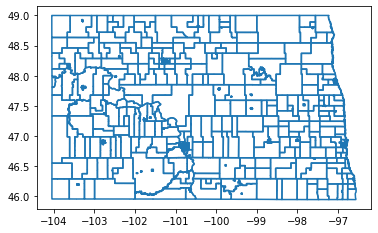

In [5]:
vest_shp.boundary.plot()

In [6]:
vest_shp.columns

Index(['STATEFP', 'COUNTYFP', 'PRECINCT', 'G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'G20PREOWRI', 'G20HALRARM', 'G20HALDRAK', 'G20HALLPET',
       'G20HALOWRI', 'G20GOVRBUR', 'G20GOVDLEN', 'G20GOVLHEN', 'G20GOVOWRI',
       'G20AUDRGAL', 'G20AUDDHAR', 'G20AUDOWRI', 'G20TRERBEA', 'G20TREDHAU',
       'G20TREOWRI', 'G20INSRGOD', 'G20INSOWRI', 'G20PSCRKRO', 'G20PSCDBUC',
       'G20PSCOWRI', 'geometry'],
      dtype='object')

## Loading, Combining Election Results
The SOS directed to this link for election results for the 2018 general: 
https://results.sos.nd.gov/ResultsSW.aspx?text=All&type=SW&map=CTY&eid=303

### Presidential Election Results

In [7]:
# Import presidential election results file
pre_20 = pd.ExcelFile("./raw-from-source/Election_Results/Statewide Precinct Results - President.xlsx")
counties = pre_20.sheet_names

# Create empty list to collect dataframes
df_pre = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(pre_20, sheet_name = county, usecols = [1,2,3,4,5], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_pre.append(df)
# Create the final dataframe    
combined_df_pre = pd.concat(df_pre)

# Rename the columns to match VEST
combined_df_pre.columns = ['County','Precinct','G20PRERTRU','G20PREDBID','G20PRELJOR','G20PREOWRI']    

# Remove the rows with column names and rows with total votes
combined_df_pre = combined_df_pre[combined_df_pre["Precinct"]!="Precinct"]
combined_df_pre = combined_df_pre[combined_df_pre["Precinct"]!="TOTALS"]

# Fill n/a values with 0
combined_df_pre = combined_df_pre.fillna(0)

# Deal with the index
combined_df_pre.reset_index(drop=True,inplace=True)

combined_df_pre.head()

,County,Precinct,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREOWRI
0,Adams,Adams County,981,258,30,0
1,Barnes,Precinct 2401-00,219,166,12,1
2,Barnes,Precinct 2402-00,437,263,31,3
3,Barnes,Precinct 2403-00,228,151,13,0
4,Barnes,Precinct 2404-00,394,247,20,2


### Representative in Congress Election Results

In [8]:
# Import house of representative election results file
hal_20 = pd.ExcelFile("./raw-from-source/Election_Results/Statewide Precinct Results - Representative.xlsx")
counties = hal_20.sheet_names

# Create empty list to collect dataframes
df_hal = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(hal_20, sheet_name = county, usecols = [1,2,3,4,5], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_hal.append(df)
# Create the final dataframe
combined_df_hal = pd.concat(df_hal)

# Rename the columns to match VEST
combined_df_hal.columns = ['County','Precinct', 'G20HALRARM','G20HALDRAK','G20HALLPET','G20HALOWRI']    

# Remove the rows with column names and rows with total votes
combined_df_hal = combined_df_hal[combined_df_hal["Precinct"]!="Precinct"]
combined_df_hal = combined_df_hal[combined_df_hal["Precinct"]!="TOTALS"]

# Fill n/a values with 0
combined_df_hal = combined_df_hal.fillna(0)

# Deal with the index
combined_df_hal.reset_index(drop=True,inplace=True)

combined_df_hal.head()

,County,Precinct,G20HALRARM,G20HALDRAK,G20HALLPET,G20HALOWRI
0,Adams,Adams County,1010,213,32,1
1,Barnes,Precinct 2401-00,241,139,16,0
2,Barnes,Precinct 2402-00,449,246,28,0
3,Barnes,Precinct 2403-00,230,135,16,2
4,Barnes,Precinct 2404-00,425,207,24,0


### Governor Election Results

In [9]:
# Import governor election results file
gov_20 = pd.ExcelFile("./raw-from-source/Election_Results/Statewide Precinct Results - Governor.xlsx")
counties = gov_20.sheet_names

# Create empty list to collect dataframes
df_gov = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(gov_20, sheet_name = county, usecols = [1,2,3,4,5], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_gov.append(df)
# Create the final dataframe
combined_df_gov = pd.concat(df_gov)

# Rename the columns to match VEST
combined_df_gov.columns = ['County','Precinct', 'G20GOVRBUR','G20GOVDLEN','G20GOVLHEN','G20GOVOWRI']    

# Remove the rows with column names and rows with total votes
combined_df_gov = combined_df_gov[combined_df_gov["Precinct"]!="Precinct"]
combined_df_gov = combined_df_gov[combined_df_gov["Precinct"]!="TOTALS"]

# Fill n/a values with 0
combined_df_gov = combined_df_gov.fillna(0)

# Deal with the index
combined_df_gov.reset_index(drop=True,inplace=True)

combined_df_gov.head()

,County,Precinct,G20GOVRBUR,G20GOVDLEN,G20GOVLHEN,G20GOVOWRI
0,Adams,Adams County,1000,163,40,57
1,Barnes,Precinct 2401-00,261,117,11,11
2,Barnes,Precinct 2402-00,484,205,23,17
3,Barnes,Precinct 2403-00,247,119,12,8
4,Barnes,Precinct 2404-00,432,182,28,21


### State Auditor Election Results

In [10]:
# Import auditor election results file
aud_20 = pd.ExcelFile("./raw-from-source/Election_Results/Statewide Precinct Results - Auditor.xlsx")
counties = aud_20.sheet_names

# Create empty list to collect dataframes
df_aud = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(aud_20, sheet_name = county, usecols = [1,2,3,4], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_aud.append(df)
# Create the final dataframe
combined_df_aud = pd.concat(df_aud)

# Rename the columns to match VEST
combined_df_aud.columns = ['County','Precinct', 'G20AUDRGAL','G20AUDDHAR','G20AUDOWRI']    

# Remove the rows with column names and rows with total votes
combined_df_aud = combined_df_aud[combined_df_aud["Precinct"]!="Precinct"]
combined_df_aud = combined_df_aud[combined_df_aud["Precinct"]!="TOTALS"]

# Fill n/a values with 0
combined_df_aud = combined_df_aud.fillna(0)

# Deal with the index
combined_df_aud.reset_index(drop=True,inplace=True)

combined_df_aud.head()

,County,Precinct,G20AUDRGAL,G20AUDDHAR,G20AUDOWRI
0,Adams,Adams County,977,250,1
1,Barnes,Precinct 2401-00,229,161,0
2,Barnes,Precinct 2402-00,416,289,1
3,Barnes,Precinct 2403-00,213,163,1
4,Barnes,Precinct 2404-00,383,252,2


### State Treasurer Election Results 

In [11]:
# Import treasurer election results file
tre_20 = pd.ExcelFile("./raw-from-source/Election_Results/Statewide Precinct Results - Treasurer.xlsx")
counties = tre_20.sheet_names

# Create empty list to collect dataframes
df_tre = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(tre_20, sheet_name = county, usecols = [1,2,3,4], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_tre.append(df)
# Create the final dataframe
combined_df_tre = pd.concat(df_tre)

# Rename the columns to match VEST
combined_df_tre.columns = ['County','Precinct','G20TRERBEA','G20TREDHAU','G20TREOWRI']    

# Remove the rows with column names and rows with total votes
combined_df_tre = combined_df_tre[combined_df_tre["Precinct"]!="Precinct"]
combined_df_tre = combined_df_tre[combined_df_tre["Precinct"]!="TOTALS"]

# Fill n/a values with 0
combined_df_tre = combined_df_tre.fillna(0)

# Deal with the index
combined_df_tre.reset_index(drop=True,inplace=True)

combined_df_tre.head()

,County,Precinct,G20TRERBEA,G20TREDHAU,G20TREOWRI
0,Adams,Adams County,926,308,4
1,Barnes,Precinct 2401-00,226,160,4
2,Barnes,Precinct 2402-00,399,302,3
3,Barnes,Precinct 2403-00,215,161,5
4,Barnes,Precinct 2404-00,378,257,8


### Insurance Commissioner Election Results

In [12]:
# Import insurance commissioner election results file
ins_20 = pd.ExcelFile("./raw-from-source/Election_Results/Statewide Precinct Results - Insurance.xlsx")
counties = ins_20.sheet_names

# Create empty list to collect dataframes
df_ins = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(ins_20, sheet_name = county, usecols = [1,2,3], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_ins.append(df)
# Create the final dataframe
combined_df_ins = pd.concat(df_ins)

# Rename the columns to match VEST
combined_df_ins.columns = ['County','Precinct','G20INSRGOD','G20INSOWRI']    

# Remove the rows with column names and rows with total votes
combined_df_ins = combined_df_ins[combined_df_ins["Precinct"]!="Precinct"]
combined_df_ins = combined_df_ins[combined_df_ins["Precinct"]!="TOTALS"]

# Fill n/a values with 0
combined_df_ins = combined_df_ins.fillna(0)

# Deal with the index
combined_df_ins.reset_index(drop=True,inplace=True)

combined_df_ins.head()

,County,Precinct,G20INSRGOD,G20INSOWRI
0,Adams,Adams County,1107,15
1,Barnes,Precinct 2401-00,322,6
2,Barnes,Precinct 2402-00,585,19
3,Barnes,Precinct 2403-00,321,5
4,Barnes,Precinct 2404-00,549,15


### Public Service Commissioner Election Results

In [13]:
# Import public service commissioner election results file
psc_20 = pd.ExcelFile("./raw-from-source/Election_Results/Statewide Precinct Results - PSC.xlsx")
counties = psc_20.sheet_names

# Create empty list to collect dataframes
df_psc = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(psc_20, sheet_name = county, usecols = [1,2,3,4], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_psc.append(df)
# Create the final dataframe
combined_df_psc = pd.concat(df_psc)

# Rename the columns to match VEST
combined_df_psc.columns = ['County','Precinct','G20PSCRKRO','G20PSCDBUC','G20PSCOWRI']    

# Remove the rows with column names and rows with total votes
combined_df_psc = combined_df_psc[combined_df_psc["Precinct"]!="Precinct"]
combined_df_psc = combined_df_psc[combined_df_psc["Precinct"]!="TOTALS"]

# Fill n/a values with 0
combined_df_psc = combined_df_psc.fillna(0)

# Deal with the index
combined_df_psc.reset_index(drop=True,inplace=True)

combined_df_psc.head()

,County,Precinct,G20PSCRKRO,G20PSCDBUC,G20PSCOWRI
0,Adams,Adams County,971,259,1
1,Barnes,Precinct 2401-00,220,153,0
2,Barnes,Precinct 2402-00,412,275,2
3,Barnes,Precinct 2403-00,221,150,1
4,Barnes,Precinct 2404-00,390,234,1


### Combine Results

In [14]:
# Concatenate all dataframes
nd_20 = pd.concat([combined_df_pre,combined_df_hal,combined_df_gov,combined_df_aud,combined_df_tre,combined_df_ins,combined_df_psc],axis=1)

# Drop repeated columns - County and Precinct
nd_20 = nd_20.loc[:,~nd_20.columns.duplicated()]

In [15]:
nd_20.columns

Index(['County', 'Precinct', 'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR',
       'G20PREOWRI', 'G20HALRARM', 'G20HALDRAK', 'G20HALLPET', 'G20HALOWRI',
       'G20GOVRBUR', 'G20GOVDLEN', 'G20GOVLHEN', 'G20GOVOWRI', 'G20AUDRGAL',
       'G20AUDDHAR', 'G20AUDOWRI', 'G20TRERBEA', 'G20TREDHAU', 'G20TREOWRI',
       'G20INSRGOD', 'G20INSOWRI', 'G20PSCRKRO', 'G20PSCDBUC', 'G20PSCOWRI'],
      dtype='object')

## Validating Election Results

### Check Statewide Candidate Totals

In [16]:
data_columns = ['G20PRERTRU', 'G20PREDBID', 'G20PRELJOR',
       'G20PREOWRI', 'G20HALRARM', 'G20HALDRAK', 'G20HALLPET', 'G20HALOWRI',
       'G20GOVRBUR', 'G20GOVDLEN', 'G20GOVLHEN', 'G20GOVOWRI', 'G20AUDRGAL',
       'G20AUDDHAR', 'G20AUDOWRI', 'G20TRERBEA', 'G20TREDHAU', 'G20TREOWRI',
       'G20INSRGOD', 'G20INSOWRI', 'G20PSCRKRO', 'G20PSCDBUC', 'G20PSCOWRI']

print("Printing differences below")
for race in data_columns:
    if (sum(vest_shp[race])- nd_20[race].sum() != 0):
        print(race+" has a difference of "+str(sum(vest_shp[race])-nd_18[race].sum())+" votes")
        print("\tVEST: "+str(sum(vest_shp[race]))+" votes")
        print("\tSOURCES: "+str(nd_20[race].sum())+" votes")
    else:
        print(race + " is equal", "\tVEST: " + str(sum(vest_shp[race])), "\tRDH: " + str(nd_20[race].sum()))
print("")
print("All other races are equal")

Printing differences below
G20PRERTRU is equal 	VEST: 235751 	RDH: 235751
G20PREDBID is equal 	VEST: 115042 	RDH: 115042
G20PRELJOR is equal 	VEST: 9371 	RDH: 9371
G20PREOWRI is equal 	VEST: 1860 	RDH: 1860
G20HALRARM is equal 	VEST: 245394 	RDH: 245394
G20HALDRAK is equal 	VEST: 98089 	RDH: 98089
G20HALLPET is equal 	VEST: 12013 	RDH: 12013
G20HALOWRI is equal 	VEST: 303 	RDH: 303
G20GOVRBUR is equal 	VEST: 235629 	RDH: 235629
G20GOVDLEN is equal 	VEST: 90925 	RDH: 90925
G20GOVLHEN is equal 	VEST: 13833 	RDH: 13833
G20GOVOWRI is equal 	VEST: 17472 	RDH: 17472
G20AUDRGAL is equal 	VEST: 234447 	RDH: 234447
G20AUDDHAR is equal 	VEST: 111397 	RDH: 111397
G20AUDOWRI is equal 	VEST: 526 	RDH: 526
G20TRERBEA is equal 	VEST: 227746 	RDH: 227746
G20TREDHAU is equal 	VEST: 117939 	RDH: 117939
G20TREOWRI is equal 	VEST: 1480 	RDH: 1480
G20INSRGOD is equal 	VEST: 295352 	RDH: 295352
G20INSOWRI is equal 	VEST: 6796 	RDH: 6796
G20PSCRKRO is equal 	VEST: 232029 	RDH: 232029
G20PSCDBUC is equal 	VES

### Check County Totals

#### County FIPs Data

In [17]:
# Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="North Dakota"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

# Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

# Create the dictionary
fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

# Modify county names in dataframe to match the FIPs file
county_name_changes_dict = {"LaMoure":"Lamoure","McKenzie":"Mckenzie","McLean":"Mclean"}
nd_20["County"] = nd_20["County"].map(county_name_changes_dict).fillna(nd_20["County"])

# Use the dictionary to go from a county name to a county FIPS
nd_20["COUNTYFP"] = nd_20["County"].map(fips_dict).fillna(nd_20["County"])

# Check the number of counties - looking for 53
print(len(nd_20["County"].unique()))

53


#### Check County Totals

In [18]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [19]:
county_totals_check(vest_shp,nd_20,data_columns,"COUNTYFP",full_print=False)

***Countywide Totals Check***

G20PRERTRU is equal across all counties
G20PREDBID is equal across all counties
G20PRELJOR is equal across all counties
G20PREOWRI is equal across all counties
G20HALRARM is equal across all counties
G20HALDRAK is equal across all counties
G20HALLPET is equal across all counties
G20HALOWRI is equal across all counties
G20GOVRBUR is equal across all counties
G20GOVDLEN is equal across all counties
G20GOVLHEN is equal across all counties
G20GOVOWRI is equal across all counties
G20AUDRGAL is equal across all counties
G20AUDDHAR is equal across all counties
G20AUDOWRI is equal across all counties
G20TRERBEA is equal across all counties
G20TREDHAU is equal across all counties
G20TREOWRI is equal across all counties
G20INSRGOD is equal across all counties
G20INSOWRI is equal across all counties
G20PSCRKRO is equal across all counties
G20PSCDBUC is equal across all counties
G20PSCOWRI is equal across all counties


### Check Precinct Totals

#### Create a 'join_col' in Both Files

In [20]:
# Create a VEST join col
vest_shp["join_col"] = vest_shp["COUNTYFP"]+"-"+vest_shp["PRECINCT"]
# Check to make sure it is unique
print(vest_shp["join_col"].value_counts(dropna=False))

# Create an election results join col
nd_20["join_col"] = nd_20["COUNTYFP"]+"-"+nd_20["Precinct"]
# Check to make sure it is unique
print(nd_20["join_col"].value_counts(dropna=False))

073-Precinct 4                  1
003-Precinct 2415-00            1
063-Precinct 1 Nelson County    1
041-New England #3              1
029-Precinct 3                  1
                               ..
079-Rolla #1                    1
049-Precinct 47                 1
061-Precinct 09                 1
059-Precinct 03                 1
097-Precinct 11                 1
Name: join_col, Length: 422, dtype: int64
073-Precinct 4                       1
059-Precinct 36                      1
057-Precinct 3313                    1
017-2101 Robert D Johnson Rec Ctr    1
063-Precinct 1 Nelson County         1
                                    ..
007-Precinct 03                      1
025-Kyseth                           1
059-Precinct 06                      1
087-Pierce Church                    1
047-Precinct 03 - Gackle School      1
Name: join_col, Length: 422, dtype: int64


#### Join Attempt #1

In [21]:
join_attempt_one = pd.merge(vest_shp,nd_20,how="outer",on="join_col",indicator=True)
join_attempt_one["_merge"].value_counts()

both          408
left_only      14
right_only     14
Name: _merge, dtype: int64

In [22]:
# Change Names to Perform Join
election_vest_id_changes_dict = {'015-Century Baptist Church 4701': '015-Century Baptist 4701', '015-Century Baptist Church 4704': '015-Century Baptist 4704', '017-1604 Faith Journey Church': '017-1604 Journey In Faith Church', '017-4102 Northview Church (formerly First Assembly)': '017-4102 Northview Church', '047-Precinct 01- American Legion': '047-Precinct 01 - American Legion', '047-Precinct 02-American Legion': '047-Precinct 02 - American Legion', '047-Precinct 04 -Lehr Com Cent.': '047-Precinct 04 - Lehr Com Cent.', '065-Precinct 02-Center /West Side': '065-Precinct 02-Center/West Side', '069-Precinct 04- 1ST WARD 1ST': '069-Precinct 04 - 1ST WARD 1ST', '069-Precinct 05- 1ST WARD 2ND': '069-Precinct 05 - 1ST WARD 2ND', '069-Precinct 06 -2ND WARD': '069-Precinct 06 - 2ND WARD', '069-Precinct 07-3RD WARD': '069-Precinct 07 - 3RD WARD', '079- Rolla #1': '079-Rolla #1', '099-Precinct 2 -District 10': '099-Precinct 2 - District 10'}
nd_20["join_col"] = nd_20["join_col"].map(election_vest_id_changes_dict).fillna(nd_20["join_col"])

#### Join Attempt #2

In [23]:
join_attempt_two = pd.merge(vest_shp,nd_20,how='outer',on="join_col",indicator="final_merge")
print(join_attempt_two["final_merge"].value_counts())

both          422
left_only       0
right_only      0
Name: final_merge, dtype: int64


#### Check Results Precinct-by-Precinct 

In [24]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["join_col"]), "(V)","{:.>5}".format(int(df.iloc[j][left_Data]))," (S){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["join_col"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["join_col"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

In [25]:
validater_row(join_attempt_two[join_attempt_two["final_merge"]=="both"],data_columns)

G20PRERTRU .........................................................059-Precinct 34 (V) .1349  (S)..140 (D):-1209
G20PRERTRU .........................................................059-Precinct 18 (V) ..580  (S)..461 (D): -119
G20PRERTRU .........................................................059-Precinct 32 (V) ..453  (S).1417 (D):  964
G20PRERTRU .........................................................059-Precinct 23 (V) ..347  (S)..231 (D): -116
G20PRERTRU .........................................................059-Precinct 17 (V) .1685  (S).1349 (D): -336
G20PRERTRU .........................................................059-Precinct 20 (V) ..545  (S)..216 (D): -329
G20PRERTRU .........................................................059-Precinct 24 (V) ..675  (S)..719 (D):   44
G20PRERTRU .........................................................059-Precinct 02 (V) ..216  (S).1685 (D): 1469
G20PRERTRU .........................................................059-Precinct 01 (V) 